# Looking into clearsky index and variability index

Clearsky index = $k = G_{measured}/G_{Clearsky}$

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go
from pvanalytics import quality
from pvlib import temperature
from pvlib import location

In [3]:
#readcsv
df = pd.read_csv("merged_df.csv")

if not isinstance(df["Timestamp"], pd.DatetimeIndex):
        df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)

In [4]:
kjeller = location.Location(latitude=59.972408, longitude=11.052408, altitude=130)    #59*58'20.6688"N, 11*3'8.6688"E

#Want to calculate the clearsky for points in the middle between each timestamp, because my dataframe is right-bounded and clearsky is calculated for the exact time. 
df['timestamp'] = pd.to_datetime(df.index)
df_temp = pd.DataFrame()
df_temp["time_middlepoint"] = pd.Series(df["timestamp"] - pd.Timedelta(minutes=2.5))
df_temp.set_index("time_middlepoint", inplace=True)
clearsky = kjeller.get_clearsky(df_temp.index, model='ineichen')
clearsky["time"] = df.index
clearsky.set_index("time", inplace=True)

In [5]:
clearsky

,ghi,dni,dhi
time,,,
2021-01-01 00:00:00+00:00,0.0,0.0,0.0
2021-01-01 00:05:00+00:00,0.0,0.0,0.0
2021-01-01 00:10:00+00:00,0.0,0.0,0.0
2021-01-01 00:15:00+00:00,0.0,0.0,0.0
2021-01-01 00:20:00+00:00,0.0,0.0,0.0
...,...,...,...
2024-08-12 21:35:00+00:00,0.0,0.0,0.0
2024-08-12 21:40:00+00:00,0.0,0.0,0.0
2024-08-12 21:45:00+00:00,0.0,0.0,0.0


Bruker ghi da det er en kombinasjon av dni og dhi regnet om til horisontalt plan. 

In [6]:
df_joined = clearsky.join(df["Irradiance (SMP10 Sunpower horisontal) [W/m²]"])

'ax.xaxis.set_major_locator(mdates.AutoDateLocator())  \nax.xaxis.set_major_formatter(mdates.DateFormatter(\'%Y-%m-%d\'))  \nax.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right") '

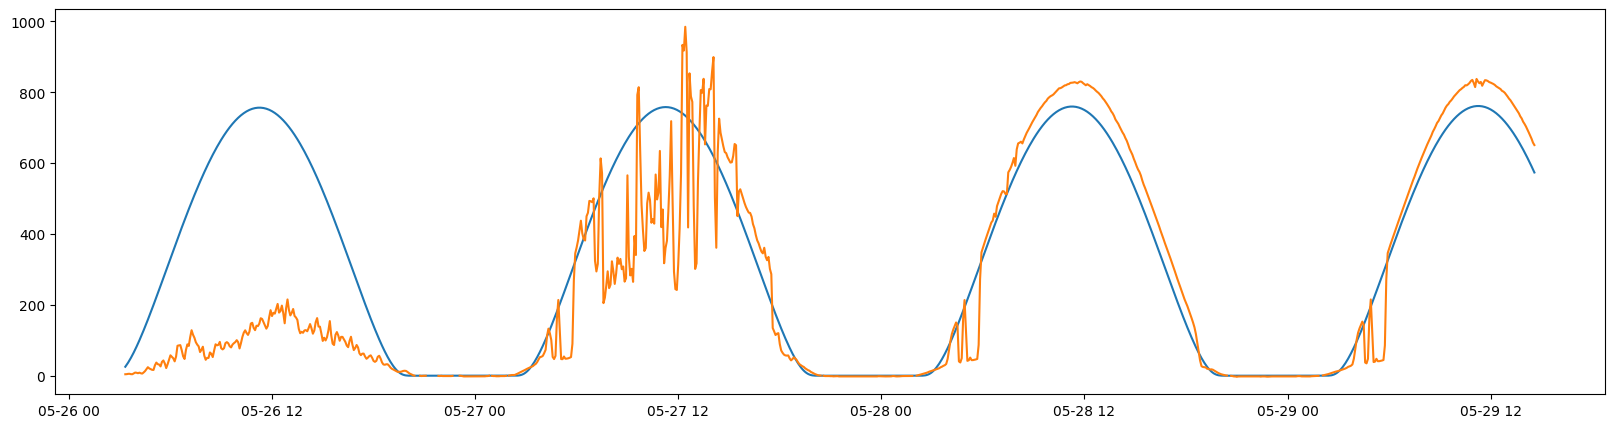

In [7]:
import matplotlib.dates as mdates

a = 41800
b = 42800
plt.figure(figsize=(20,5))
plt.plot(df_joined.index[a:b], df_joined["ghi"][a:b])
plt.plot(df_joined.index[a:b], df_joined["Irradiance (SMP10 Sunpower horisontal) [W/m²]"][a:b])
'''ax.xaxis.set_major_locator(mdates.AutoDateLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
ax.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right") '''

Ser forskjøvet ut, men er joinet på timestamp, så burde ikke være det? 

Men ser bra ut å bruke 26., 27. og 28. mai i 2021, da de er overskyet, variert og tilnærmet clearsky. 

In [8]:
from pvlib import irradiance
#Clearsky index
#df_joined["k"] = df_joined["Irradiance (SMP10 Sunpower horisontal) [W/m²]"] / df_joined["ghi"]
#df_joined["k"] = np.where(df_joined["ghi"] < 10, 0, df_joined["Irradiance (SMP10 Sunpower horisontal) [W/m²]"] / df_joined["ghi"])
df_joined["k"] = irradiance.clearsky_index(df_joined["Irradiance (SMP10 Sunpower horisontal) [W/m²]"], df_joined["ghi"], max_clearsky_index = 2.0 )

daily_clearsky = df_joined.resample('d').apply(lambda x: np.mean(x["k"]))

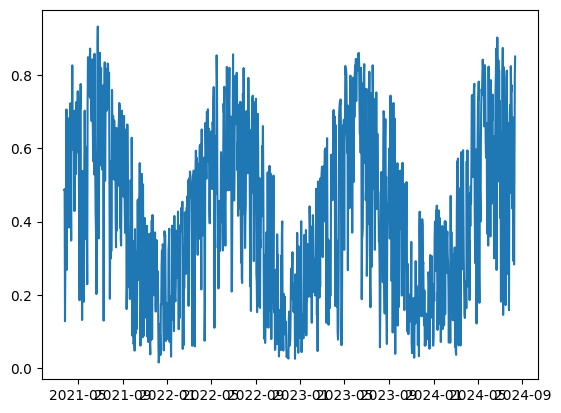

In [9]:
plt.plot(daily_clearsky)

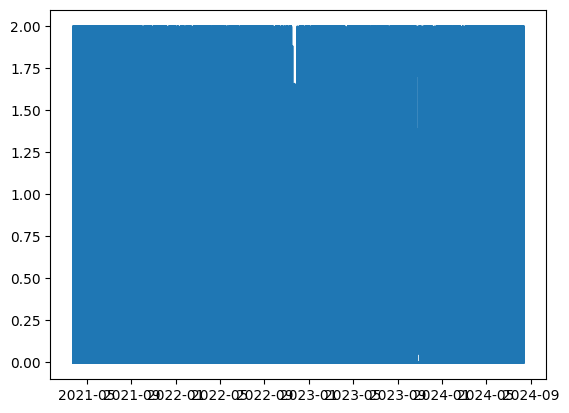

In [10]:
plt.plot(df_joined["k"])

In [ ]:
#Variability index
df_joined["k_i-1"] = df_joined["k"].shift(-1)
, ir,           e ddsdsheonanksnghjghjfjhfhhjghjgjfyftfyf bbvhgugu
def variability(x1, x2):
    return np.sqrt(np.mean((x1 - x2)**2))

df_joined.dropna(how="all")

daily_variablity = df_joined.resample('d').apply(lambda x: np.sqrt(np.mean((x["k"] - x["k_i-1"])**2)))

#daily_variablity = (((df_joined["k"] - df_joined["k"].shift(periods=-1, freq='5 min'))**2).resample('d')).mean().apply(np.sqrt)

In [12]:
daily_variablity.index

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-02 00:00:00+00:00',
               '2021-01-03 00:00:00+00:00', '2021-01-04 00:00:00+00:00',
               '2021-01-05 00:00:00+00:00', '2021-01-06 00:00:00+00:00',
               '2021-01-07 00:00:00+00:00', '2021-01-08 00:00:00+00:00',
               '2021-01-09 00:00:00+00:00', '2021-01-10 00:00:00+00:00',
               ...
               '2024-08-03 00:00:00+00:00', '2024-08-04 00:00:00+00:00',
               '2024-08-05 00:00:00+00:00', '2024-08-06 00:00:00+00:00',
               '2024-08-07 00:00:00+00:00', '2024-08-08 00:00:00+00:00',
               '2024-08-09 00:00:00+00:00', '2024-08-10 00:00:00+00:00',
               '2024-08-11 00:00:00+00:00', '2024-08-12 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=1320, freq='D')

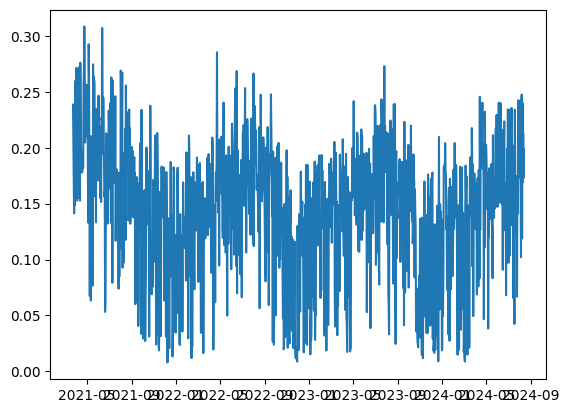

In [13]:
plt.plot(daily_variablity[:100000])

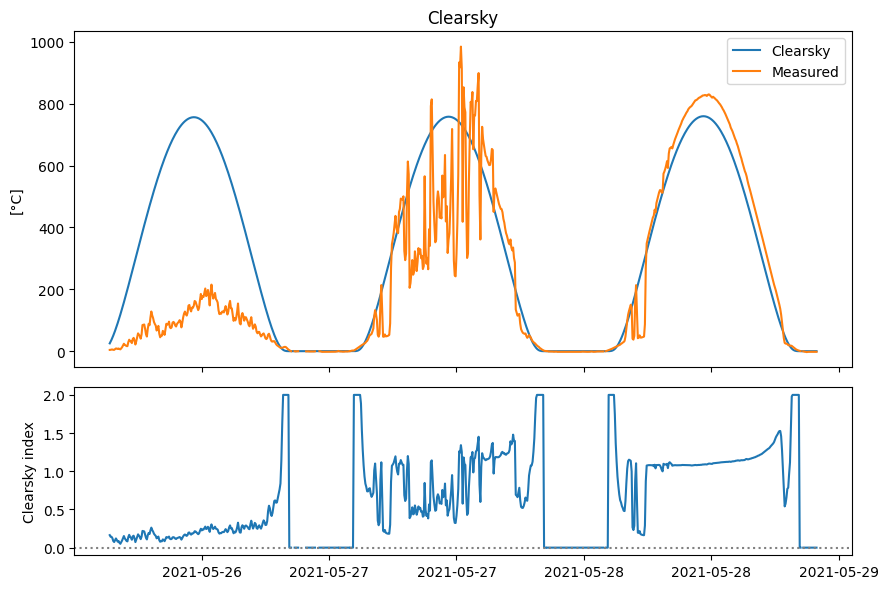

In [14]:
a = 41800
b = 42600


if not isinstance(df_joined.index, pd.DatetimeIndex):
    df_joined.index = pd.to_datetime(df_joined.index)

#x = x.asfreq('h')

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 6), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
ax1.set_title(f"Clearsky")
ax1.plot(df_joined.index[a:b], df_joined["ghi"][a:b], label = "Clearsky")
ax1.plot(df_joined.index[a:b], df_joined["Irradiance (SMP10 Sunpower horisontal) [W/m²]"][a:b], label = "Measured")
ax1.set_ylabel("[°C]")
#ax2.set_title("Residuals")
ax2.plot(df_joined.index[a:b], df_joined["k"][a:b])
#ax2.plot(df_joined.index[a:b],)
ax2.set_ylabel("Clearsky index")
ax2.axhline(0, c="grey", linestyle=":")
ax1.legend()
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())  
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
#plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right") 
plt.tight_layout()
plt.show()

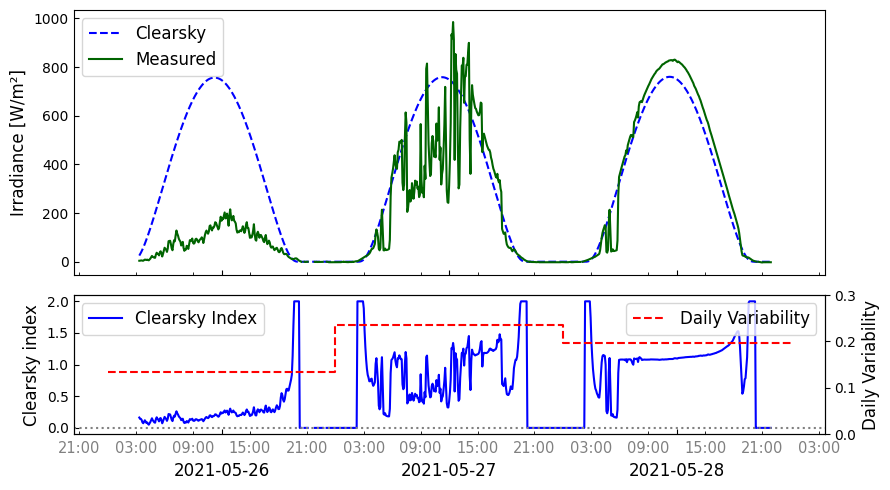

In [52]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 5), gridspec_kw={'height_ratios': [1.9, 1]}, sharex=True)

#ax1.set_title("Comparing measured irradiance with clearsky conditions")
ax1.plot(df_joined.index[a:b], df_joined["ghi"][a:b], label="Clearsky", color="b", linestyle="--")
ax1.plot(df_joined.index[a:b], df_joined["Irradiance (SMP10 Sunpower horisontal) [W/m²]"][a:b], label="Measured", color="darkgreen")
ax1.set_ylabel("Irradiance [W/m²]", fontsize=12)
ax1.legend( fontsize=12)
ax1.tick_params(which="both", direction="in")

ax2.plot(df_joined.index[a:b], df_joined["k"][a:b], label="Clearsky Index", color="b")
ax2.set_ylabel("Clearsky index", fontsize=12)
ax2.axhline(0, c="grey", linestyle=":")
ax2.legend(loc="upper left", fontsize=12)

ax2_secondary = ax2.twinx()
ax2_secondary.set_ylabel("Daily Variability", fontsize=12) 
ax2_secondary.set_ylim(0, 0.3)
ax2_secondary.step(daily_variablity.index[a//(24*12):b//(24*12)+2], daily_variablity[a//(24*12):b//(24*12)+2], where="post", color='red', label="Daily Variability", linestyle="--")

#ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_locator(mdates.HourLocator(byhour=12))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_minor_locator(mdates.HourLocator(byhour=[3, 9, 15, 21]))  
ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0, fontsize=12)  
plt.setp(ax2.xaxis.get_minorticklabels(), rotation=0, fontsize=10, color="gray")
ax2.tick_params(axis='x', which='major', pad=20, direction="in", labelsize=12)  
ax2.tick_params(axis='x', which='minor', pad=5, labelsize=10.5, labelcolor="gray", direction="in")
ax2.tick_params(which="both", direction="in")

ax2_secondary.legend(loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig("img/clearsky_comparison", bbox_inches='tight')
plt.show()


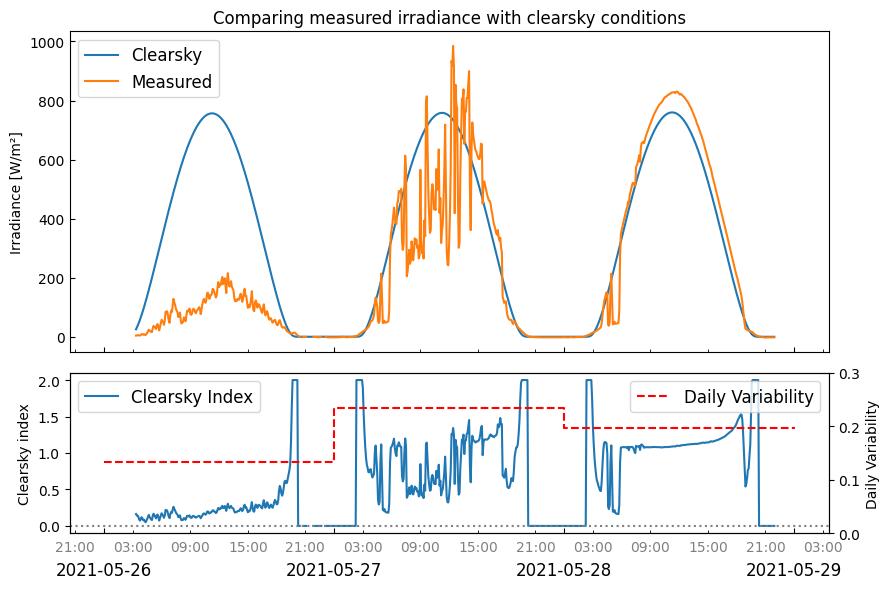

In [26]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 6), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

ax1.set_title("Comparing measured irradiance with clearsky conditions")
ax1.plot(df_joined.index[a:b], df_joined["ghi"][a:b], label="Clearsky")
ax1.plot(df_joined.index[a:b], df_joined["Irradiance (SMP10 Sunpower horisontal) [W/m²]"][a:b], label="Measured")
ax1.set_ylabel("Irradiance [W/m²]")
ax1.legend( fontsize=12)
ax1.tick_params(which="both", direction="in")

ax2.plot(df_joined.index[a:b], df_joined["k"][a:b], label="Clearsky Index")
ax2.set_ylabel("Clearsky index")
ax2.axhline(0, c="grey", linestyle=":")
ax2.legend(loc="upper left", fontsize=12)

ax2_secondary = ax2.twinx()
ax2_secondary.set_ylabel("Daily Variability") 
ax2_secondary.set_ylim(0, 0.3)
ax2_secondary.step(daily_variablity.index[a//(24*12):b//(24*12)+2], daily_variablity[a//(24*12):b//(24*12)+2], where="post", color='red', label="Daily Variability", linestyle="--")

# Major ticks: One tick per day for the full date
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Minor ticks: Ensure they occur at every 6-hour interval (including 00:00 and 12:00)
ax2.xaxis.set_minor_locator(mdates.HourLocator(byhour=[3, 9, 15, 21]))#interval=6))  # 0, 6, 12, 18 hours
ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

# Label formatting
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0, fontsize=12)
plt.setp(ax2.xaxis.get_minorticklabels(), rotation=0, fontsize=10, color="gray")

# Minor tick adjustments to ensure labels show both 00:00 and 12:00
ax2.tick_params(axis='x', which='major', pad=20, direction="in")
ax2.tick_params(axis='x', which='minor', pad=5, labelsize=10, labelcolor="gray", direction="in", labelrotation=0)


ax2_secondary.legend(loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig("img/clearsky_irradiance", bbox_inches="tight")
plt.show()


In [ ]:
datea = '2021-05-26'
dateb = '2021-05-27'
datec = '2021-05-28'
daily_clearsky.loc[datea]

0.22854425130729655

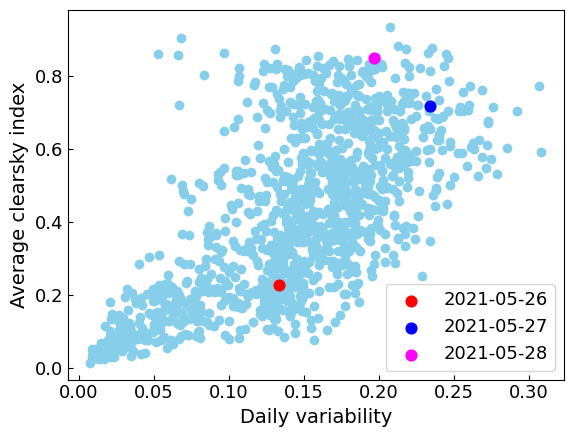

In [ ]:
plt.scatter(daily_variablity, daily_clearsky, color="skyblue")
plt.scatter(daily_variablity.loc[datea], daily_clearsky.loc[datea], color="red", label=datea, s=60)
plt.scatter(daily_variablity.loc[dateb], daily_clearsky.loc[dateb], color="blue", label=dateb, s=60)
plt.scatter(daily_variablity.loc[datec], daily_clearsky.loc[datec], color="magenta", label=datec, s=60)
plt.xlabel("Daily variability", size=14)
plt.ylabel("Average clearsky index", size=14)
plt.tick_params(direction="in", labelsize=13)
plt.legend(fontsize=13)
plt.savefig("img/clearsky_scatter")
#plt.show()